# 1. About CNN

CNN - Convolutional Neural Networks          
CNN is a neural network model that is mainly used to process images or image data and includes a preprocessing task called convolution.

# 2. About cat & dog dataset

This dataset is very easy to start CNN. So our study group select this to practice CNN modeling.         

* The dataset provide 25000 cats and dogs images to classify.

In [1]:
''' importing library''' 

import numpy as np
import sys
import tensorflow as tf
import os
import sys
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

In [2]:
'''setting seed'''
seed = 0
np.random.seed(seed)
tf.random.set_seed(3)

Data files are zip file. So we have to unzip data files.

In [6]:
import zipfile

zip_files = ['test1', 'train']

for zip_file in zip_files:
    with zipfile.ZipFile("./{}.zip".format(zip_file),"r") as z:
        z.extractall(".")
        print("{} unzipped".format(zip_file))

test1 unzipped
train unzipped


In [10]:
'''test1, train Data is in current working folder'''
print(os.listdir('./'))

['.ipynb_checkpoints', 'Dogs vs. Cats with AlexNet.ipynb', 'it-rainning-cat-and-dog-cnn.ipynb', 'test1', 'test1.zip', 'train', 'train.zip']


In [42]:
IMAGE_FOLDER_PATH = "./train"
FILE_NAMES = os.listdir(IMAGE_FOLDER_PATH)
WIDTH = 227
HEIGHT = 227

In [43]:
FILE_NAMES[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.10.jpg', 'cat.100.jpg', 'cat.1000.jpg']

Make new dataset for image_path, target data.

In [44]:
# empty list
targets = list()
full_paths = list()
train_cats_dir = list()
train_dogs_dir = list()

# finding each file's target
for file_name in FILE_NAMES:
    target = file_name.split(".")[0] # target name
    full_path = os.path.join(IMAGE_FOLDER_PATH, file_name)
    
    if(target == "dog"):
        train_dogs_dir.append(full_path)
    if(target == "cat"):
        train_cats_dir.append(full_path)
    
    full_paths.append(full_path)
    targets.append(target)

dataset = pd.DataFrame() # make dataframe
dataset['image_path'] = full_paths # file path
dataset['target'] = targets # file's target

In [45]:
dataset['image_path']

0           ./train\cat.0.jpg
1           ./train\cat.1.jpg
2          ./train\cat.10.jpg
3         ./train\cat.100.jpg
4        ./train\cat.1000.jpg
                 ...         
24995    ./train\dog.9995.jpg
24996    ./train\dog.9996.jpg
24997    ./train\dog.9997.jpg
24998    ./train\dog.9998.jpg
24999    ./train\dog.9999.jpg
Name: image_path, Length: 25000, dtype: object

In [46]:
dataset['target']

0        cat
1        cat
2        cat
3        cat
4        cat
        ... 
24995    dog
24996    dog
24997    dog
24998    dog
24999    dog
Name: target, Length: 25000, dtype: object

In [47]:
dataset.head(10)

,image_path,target
0,./train\cat.0.jpg,cat
1,./train\cat.1.jpg,cat
2,./train\cat.10.jpg,cat
3,./train\cat.100.jpg,cat
4,./train\cat.1000.jpg,cat
5,./train\cat.10000.jpg,cat
6,./train\cat.10001.jpg,cat
7,./train\cat.10002.jpg,cat
8,./train\cat.10003.jpg,cat
9,./train\cat.10004.jpg,cat


In [48]:
print("total data counts:", dataset['target'].count())
counts = dataset['target'].value_counts()
print(counts)

total data counts: 25000
cat    12500
dog    12500
Name: target, dtype: int64


## cat data

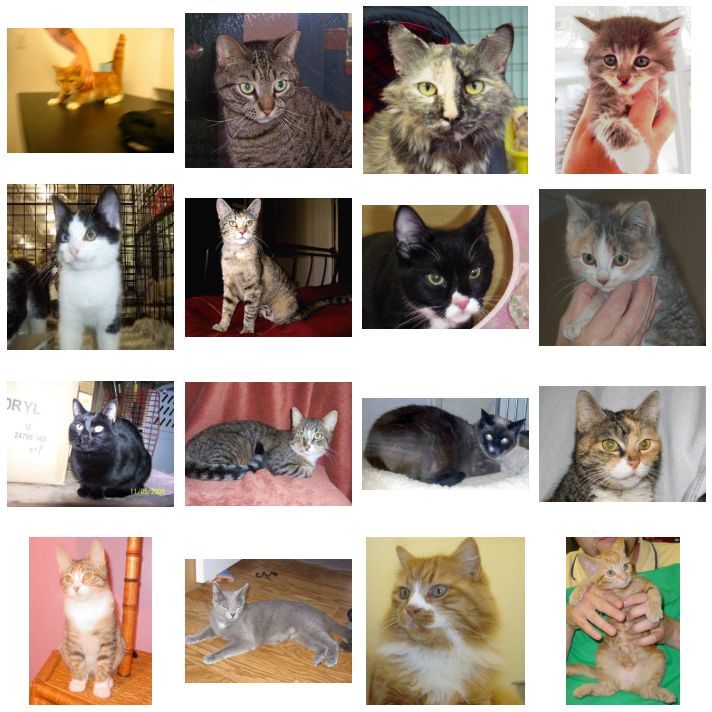

In [10]:
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_cats_dir[i])
    sp = fig.add_subplot(rows,cols,a+1);
    axes.append(sp);
    sp.axis('off');
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

## dog data

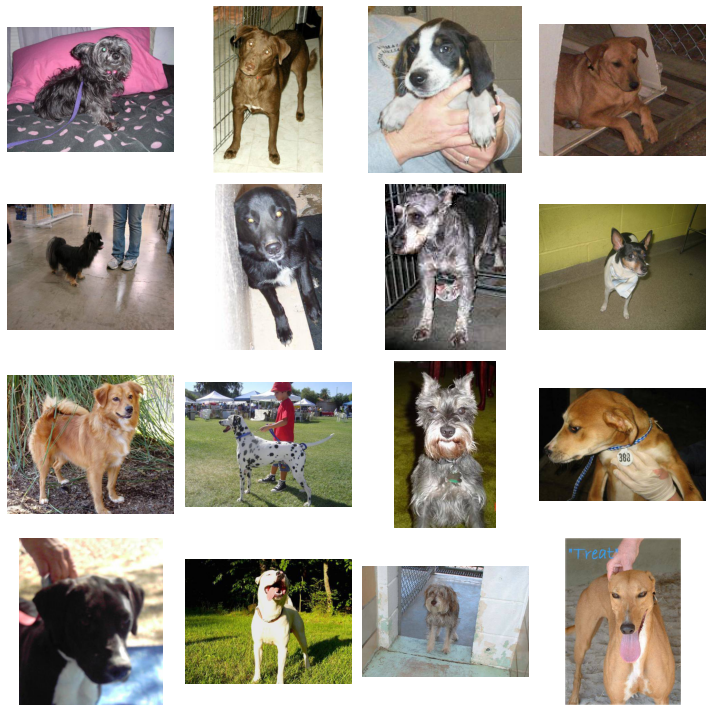

In [11]:
rows = 4
cols = 4
axes = []
fig=plt.figure(figsize=(10,10))
i = 0

for a in range(rows*cols):
    b = mpimg.imread(train_dogs_dir[i])
    sp = fig.add_subplot(rows,cols,a+1);
    axes.append(sp);
    sp.axis('off');
    plt.imshow(b)
    i+=1
fig.tight_layout()
plt.show()

# 3. Data preprocessing

## Reason for rescaling
* The brightness of each pixel is between 0 and 255.
* Keras performs optimally when data's value is between 0 and 1.
* This process is called data normalization.

## data split
To prevent overfitting, the data should be divided into train data and test data.
* [about overfitting](https://en.wikipedia.org/wiki/Overfitting)

In [49]:
dataset_train, dataset_test = train_test_split(dataset, test_size=0.2, random_state=seed)

## ImageDataGenerator (모딥 p.307)
When there is little data to train, we have to use **ImageDataGenerator** to increase the number of data.
It is recommended to use only scaling for **test data**.

* rescale = 1./255 : change the value between 0 and 1
* rotation_range = 15 : Random rotation within 15 degrees
* shear_range = 0.1 : shear range 10%
* zoom_range = 0.2 : zoom range 20%
* horizontal_flip = True : Randomly flip horizontally.
* width_shift_range = 0.1 : Randomly move the original image horizontally within 10% of the width
* height_shift_range=0.1 : Randomly move the original image vertically within 10% of the width

[about ImageDataGenerator_kor.ver](https://keras.io/ko/preprocessing/image/)

[about ImageDataGenerator_Image change process_kor.ver](https://tykimos.github.io/2017/06/10/CNN_Data_Augmentation/)

## flow_from_dataframe
Save the image data data to the pandas data frame and send it to the ImageDataGenerator.

* dataframe: Dataframe must consist of file path and target
* x_col: column in 'dataframe' that contains the filenames
* y_col: column in 'dataframe' that has the target data.
* target_size: image size
* class_mode: "binary" -> binary classification, "categorical" -> categorical classification (the data should be one-hot encoded label)
* batch_size: size of data batch

In [50]:
train_datagen = ImageDataGenerator(
rotation_range=15,
rescale=1./255,
shear_range=0.1,
zoom_range=0.2,
horizontal_flip=True,
width_shift_range=0.1,
height_shift_range=0.1)

train_datagenerator = train_datagen.flow_from_dataframe(dataframe=dataset_train,
                                                     x_col="image_path",
                                                     y_col="target",
                                                     target_size=(WIDTH, HEIGHT),
                                                     class_mode="binary",
                                                     batch_size=150)

Found 20000 validated image filenames belonging to 2 classes.


In [51]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_datagenerator = test_datagen.flow_from_dataframe(dataframe=dataset_test,
                                                   x_col="image_path",
                                                   y_col="target",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode="binary",
                                                   batch_size=150)

Found 5000 validated image filenames belonging to 2 classes.


In [52]:
test_datagenerator[0]

(array([[[[0.70980394, 0.6392157 , 0.54509807],
          [0.70980394, 0.6392157 , 0.54509807],
          [0.7058824 , 0.63529414, 0.5411765 ],
          ...,
          [0.76470596, 0.72156864, 0.6039216 ],
          [0.7607844 , 0.7176471 , 0.6392157 ],
          [0.7411765 , 0.69803923, 0.61960787]],
 
         [[0.6901961 , 0.61960787, 0.5254902 ],
          [0.7058824 , 0.63529414, 0.5411765 ],
          [0.72156864, 0.6509804 , 0.5568628 ],
          ...,
          [0.7607844 , 0.6901961 , 0.59607846],
          [0.77647066, 0.7058824 , 0.61960787],
          [0.7843138 , 0.7137255 , 0.627451  ]],
 
         [[0.69803923, 0.627451  , 0.53333336],
          [0.7176471 , 0.64705884, 0.5529412 ],
          [0.7137255 , 0.6431373 , 0.54901963],
          ...,
          [0.7372549 , 0.64705884, 0.58431375],
          [0.75294125, 0.64705884, 0.5647059 ],
          [0.77647066, 0.67058825, 0.5882353 ]],
 
         ...,
 
         [[0.77647066, 0.7254902 , 0.6627451 ],
          [0.78039

# 4. CNN model

## model

In [31]:
# def create_model():

#   model = tf.keras.models.Sequential([ 
#     tf.keras.layers.Conv2D(16,(3,3), activation = 'relu', input_shape=(150,150,3)),
#     tf.keras.layers.MaxPooling2D(2,2),

#     tf.keras.layers.Conv2D(32,(3,3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),

#     tf.keras.layers.Conv2D(64,(3,3), activation = 'relu'),
#     tf.keras.layers.MaxPooling2D(2,2),

#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(512, activation = 'relu'),
#     tf.keras.layers.Dense(1, activation='sigmoid')
#   ])

  
#   model.compile(optimizer=RMSprop(lr=0.001),
#                 loss='binary_crossentropy',
#                 metrics=['accuracy']) 
    
#   return model

In [53]:
def create_model():

  model = tf.keras.models.Sequential([ 
    tf.keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
          
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='softmax')
  ])
  
  model.compile(optimizer=RMSprop(lr=0.001),
                loss='binary_crossentropy',
                metrics=['accuracy']) 
    
  return model

In [54]:
model = create_model()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 batch_normalization_10 (Bat  (None, 55, 55, 96)       384       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 27, 27, 96)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_11 (Bat  (None, 27, 27, 256)      1024      
 chNormalization)                                                
                                                      

C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [55]:
model.compile(loss="binary_crossentropy", optimizer='adam', metrics=['accuracy'])
print("[INFO]: model compiled...")

[INFO]: model compiled...


In [56]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs={}):
        if(logs.get('val_accuracy')>=0.90):
            self.model.stop_training = True
            
callback = mycallback()

## Training

In [ ]:
modelHistory=model.fit(train_datagenerator,
                       epochs=1,
                       validation_data=test_datagenerator,
                       validation_steps=dataset_test.shape[0]/150,
                       steps_per_epoch=dataset_train.shape[0]/150,
                       callbacks=[callback])

 87/133 [==================>...........] - ETA: 7:07 - loss: 3.4452 - accuracy: 0.5035

## Accuracy

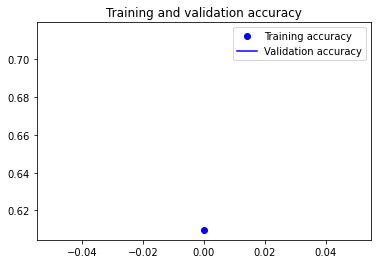

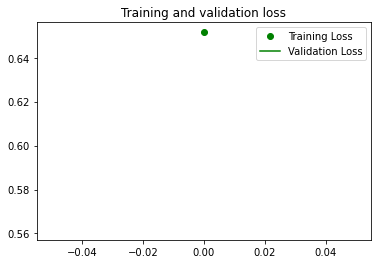

In [36]:
acc = modelHistory.history['accuracy']
val_acc = modelHistory.history['val_accuracy']
loss = modelHistory.history['loss']
val_loss = modelHistory.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Test

In [22]:
IMAGE_FOLDER_PATH2 = "./test1"
FILE_NAMES2 = os.listdir(IMAGE_FOLDER_PATH2)
WIDTH = 227
HEIGHT = 227

In [23]:
FILE_NAMES2[0:5]

['1.jpg', '10.jpg', '100.jpg', '1000.jpg', '10000.jpg']

In [24]:
full_paths2 = list()

for file_name in FILE_NAMES2:
    full_path2 = os.path.join(IMAGE_FOLDER_PATH2, file_name)
    full_paths2.append(full_path2)
    
dataset2 = pd.DataFrame() # make dataframe
dataset2['image_path'] = full_paths2 # file path
dataset2['image_path']

0            ./test1\1.jpg
1           ./test1\10.jpg
2          ./test1\100.jpg
3         ./test1\1000.jpg
4        ./test1\10000.jpg
               ...        
12495     ./test1\9995.jpg
12496     ./test1\9996.jpg
12497     ./test1\9997.jpg
12498     ./test1\9998.jpg
12499     ./test1\9999.jpg
Name: image_path, Length: 12500, dtype: object

In [25]:
dataset2['pictures'] = FILE_NAMES2
dataset2['pictures']

0            1.jpg
1           10.jpg
2          100.jpg
3         1000.jpg
4        10000.jpg
           ...    
12495     9995.jpg
12496     9996.jpg
12497     9997.jpg
12498     9998.jpg
12499     9999.jpg
Name: pictures, Length: 12500, dtype: object

In [26]:
dataset2.head(10)

,image_path,pictures
0,./test1\1.jpg,1.jpg
1,./test1\10.jpg,10.jpg
2,./test1\100.jpg,100.jpg
3,./test1\1000.jpg,1000.jpg
4,./test1\10000.jpg,10000.jpg
5,./test1\10001.jpg,10001.jpg
6,./test1\10002.jpg,10002.jpg
7,./test1\10003.jpg,10003.jpg
8,./test1\10004.jpg,10004.jpg
9,./test1\10005.jpg,10005.jpg


In [27]:
pred_datagen = ImageDataGenerator(rescale=1./255)
pred_datagenerator = pred_datagen.flow_from_dataframe(dataframe=dataset2,
                                                   x_col="image_path",
                                                   target_size=(WIDTH, HEIGHT),
                                                   class_mode=None,
                                                   batch_size=150)

Found 12500 validated image filenames.


In [28]:
test_output = model.predict(pred_datagenerator)

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [32]:
x = test_output
np.savetxt('predict result',x)

## 其他讀入圖片的方法

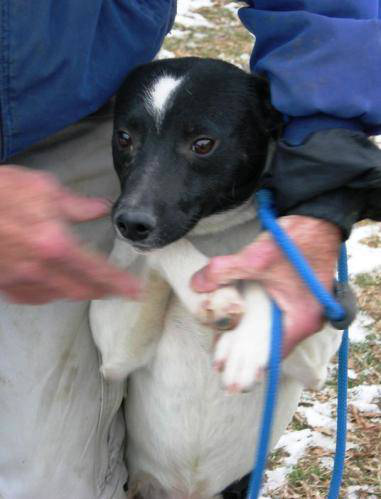

In [65]:
from PIL import Image
img=Image.open('./test1/1.jpg')
img

In [66]:
test = plt.imread('./test1/1.jpg')
test

array([[[ 37,  64,  94],
        [ 35,  62,  92],
        [ 34,  60,  93],
        ...,
        [ 71, 108, 199],
        [ 49,  86, 175],
        [ 48,  85, 173]],

       [[ 41,  68,  98],
        [ 39,  66,  96],
        [ 37,  63,  96],
        ...,
        [ 71, 106, 198],
        [ 48,  85, 174],
        [ 47,  84, 172]],

       [[ 45,  72, 102],
        [ 43,  70, 100],
        [ 40,  66,  99],
        ...,
        [ 70, 105, 199],
        [ 48,  83, 173],
        [ 47,  83, 171]],

       ...,

       [[165, 169, 170],
        [167, 171, 174],
        [171, 174, 179],
        ...,
        [ 97,  89,  70],
        [ 85,  77,  54],
        [ 87,  77,  52]],

       [[168, 172, 173],
        [169, 173, 176],
        [172, 175, 180],
        ...,
        [116, 108,  89],
        [105,  97,  74],
        [108,  98,  73]],

       [[173, 177, 178],
        [172, 176, 179],
        [172, 175, 180],
        ...,
        [125, 117,  98],
        [115, 107,  84],
        [118, 108,  83]]

In [43]:
test_output = model.predict(test)
test_output

ValueError: in user code:

    File "C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Selena Huang\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential" is incompatible with the layer: expected shape=(None, 227, 227, 3), found shape=(None, 381, 3)
